<a href="https://colab.research.google.com/github/yeshurunlevi/popularity-of-restaurants-in-Greece/blob/main/popularity_of_restaurants_in_Greece.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

columns:

link - ID?

name - name

original_location - list of all

claimed - restaurant business claimed on TripAdvisor

awards - awards, when get.

popularity_detailed - popularity detailed ranking

popularity_generic - popularity generic ranking (among all places to eat in the area)

top_tags - top tag names (key words?)

price_level - level of prices in current currency (data scraped from www.tripadvisor.ie - so currency is €)

price_range - range of prices in current currency (ranges displayed on TripAdvisor seem to be quite unreliable)

meals - types of meal

cuisines - types of cuisine

special_diets - types of special diets

features - restaurant features

vegetarian_friendly - is the restaurant vegetarian friendly?

vegan_options - does the restaurant offer vegan options?

gluten_free - does the restaurant gluten-free options?

##edit_1

In [26]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

df = pd.read_csv(r'/content/drive/MyDrive/Trip Advisor EU restaurants /tripadvisor_european_restaurants.csv')

<ipython-input-26-9216e2ab3be7>:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'/content/drive/MyDrive/Trip Advisor EU restaurants /tripadvisor_european_restaurants.csv')


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083397 entries, 0 to 1083396
Data columns (total 42 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   restaurant_link                    1083397 non-null  object 
 1   restaurant_name                    1083396 non-null  object 
 2   original_location                  1083397 non-null  object 
 3   country                            1083397 non-null  object 
 4   region                             1033074 non-null  object 
 5   province                           742765 non-null   object 
 6   city                               682712 non-null   object 
 7   address                            1083397 non-null  object 
 8   latitude                           1067607 non-null  float64
 9   longitude                          1067607 non-null  float64
 10  claimed                            1081555 non-null  object 
 11  awards                  

In [28]:
df2 = df.copy()
df2 = df2[(df['total_reviews_count'] >= 10) & (df['country'] == 'Greece')]

#df2 = df2.applymap(lambda x: x.replace(" ", "") if isinstance(x, str) else x)
df2 = df2.applymap(lambda x: x.lower() if isinstance(x, str) else x)


def succ(x):
  if x >= 4.5:
    return 1
  else:
    return 0
df2['success (target)'] = [succ(x) for x in df2['avg_rating']]

<ipython-input-28-f49f0068eb8d>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [29]:
df2['success (target)'].value_counts()

,count
success (target),
1,13796
0,8194


In [30]:
# Extract only the ranking number, handling NaNs
df2["popularity_detailed"], df2["restaurants"] = df["popularity_detailed"].str.extract(r'#(\d)'), df["popularity_detailed"].str.extract(r'#(\d+)')
df2["popularity_generic"], df2["places"] = df["popularity_generic"].str.extract(r'#(\d)'), df["popularity_generic"].str.extract(r'#(\d+)')

df2["popularity_detailed"], df2["restaurants"], df2["popularity_generic"], df2["places"] = df2["popularity_detailed"].astype(float), df2["restaurants"].astype(float), df2["popularity_generic"].astype(float), df2["places"].astype(float)

In [31]:

df2['price_level'] = df['price_level'].map({'€': 1, '€€-€€€': 2.5, '€€€€': 4})
df2['claimed'] = df['claimed'].map({'Claimed': 1, 'Unclaimed': 0})
df2['default_language'] = df['default_language'].map({'English': 0, 'All languages': 1})

In [32]:

import ast

# Function to process opening hours safely
def process_opening_hours(opening_hours):
    if not isinstance(opening_hours, str) or not opening_hours.strip():
        return [None, None, None, None, None, None]  # Handles None, NaN, or empty string

    try:
        hours_dict = ast.literal_eval(opening_hours)
        if not isinstance(hours_dict, dict):
            return [0, 0, 0, 0, 0, 0]

        total_days_open = 0
        total_hours = 0
        morning, noon, evening, night = 0, 0, 0, 0

        for day, periods in hours_dict.items():
            if periods:
                total_days_open += 1
                daily_hours = 0
                full_day_flag = False

                for period in periods:
                    start, end = period.split('-')
                    start_hour, start_minute = map(int, start.split(':'))
                    end_hour, end_minute = map(int, end.split(':'))

                    # Convert to float hours
                    start_time = start_hour + start_minute / 60
                    end_time = end_hour + end_minute / 60

                    # Handle cases where closing time is past midnight
                    if end_time < start_time:
                        end_time += 24

                    hours_open = end_time - start_time
                    daily_hours += hours_open

                    # Check time slots
                    if start_time < 6:
                        night = 1
                    if start_time < 12 and end_time > 6:
                        morning = 1
                    if start_time < 18 and end_time > 12:
                        noon = 1
                    if start_time < 24 and end_time > 18:
                        evening = 1
                    if hours_open >= 12:
                        full_day_flag = True

                total_hours += daily_hours

        avg_hours_per_day = total_hours / total_days_open if total_days_open else 0
        return [total_days_open, round(avg_hours_per_day, 1), morning, noon, evening, night]


    except (SyntaxError, ValueError, AttributeError, TypeError):
        return [0, 0, 0, 0, 0, 0]  # Safe fallback if parsing fails

# Apply function safely
df2[['open_days', 'avg_hours_per_day', 'morning', 'noon', 'evening', 'night']] = df2['original_open_hours'].apply(process_opening_hours).apply(pd.Series)

# Drop the original column
#df.drop(columns=['opening_hours'], inplace=True)




In [33]:
import statistics
def extract_prices(price_range):
    if pd.isna(price_range):
        return np.nan, np.nan  # Keep NaN for missing values
    else:
      prices = price_range.replace("€", "").replace(",", "").split("-")  # Remove € and split
    return [int(prices[0]), int(prices[1])]  # Convert to integers

# Apply function and create new columns
df2["min_price"] =[extract_prices(cell)[0] for cell in df2["price_range"]]
df2["max_price"] =[extract_prices(cell)[1] for cell in df2["price_range"]]

In [34]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21990 entries, 952974 to 986735
Data columns (total 53 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   restaurant_link                    21990 non-null  object 
 1   restaurant_name                    21990 non-null  object 
 2   original_location                  21990 non-null  object 
 3   country                            21990 non-null  object 
 4   region                             21990 non-null  object 
 5   province                           18520 non-null  object 
 6   city                               21987 non-null  object 
 7   address                            21990 non-null  object 
 8   latitude                           21340 non-null  float64
 9   longitude                          21340 non-null  float64
 10  claimed                            21983 non-null  float64
 11  awards                             10731 non-null  ob

In [35]:
import re

df2['awards'].fillna(' ', inplace=True)  # Replace NaN

# Apply function and expand into new columns
df2['excellence'] = [len(re.findall(r"excellence", cell, re.IGNORECASE)) for cell in df2['awards']]
df2['michelin'] = [len(re.findall(r"michelin", cell, re.IGNORECASE)) for cell in df2['awards']]
df2['another'] = [len(re.findall(r"worth", cell, re.IGNORECASE)) + len(re.findall(r"good", cell, re.IGNORECASE)) for cell in df2['awards']]

<ipython-input-35-6a08d63cc9ef>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['awards'].fillna(' ', inplace=True)  # Replace NaN


In [36]:
# Function to clean and split addresses
def clean_and_split_address(address):
    address = address.lower().replace("greece", "").strip()  # Remove "Greece"

    # Ensure we have at least a street and city/zip
    parts = address.split(",", 1) if "," in address else [address, ""]

    street_info = parts[0].strip()  # Street + number
    city_zip = parts[1].strip() if len(parts) > 1 else ""  # City + ZIP if available

    # Extract ZIP code and city
    zip_code = []
    city = []
    for char in city_zip:
        if char.isdigit():
            zip_code.append(char)
        else:
            city.append(char)

    city = "".join(city).strip()
    zip_code = "".join(zip_code)

    # Extract Apartment Number and Street Name
    apartment_number = []
    street_name = []
    for char in street_info:
        if char.isdigit():
            apartment_number.append(char)
        else:
            street_name.append(char)

    street_name = "".join(street_name).strip()
    apartment_number = "".join(apartment_number)

    return pd.Series([apartment_number, street_name, city, zip_code])

# Apply function to DataFrame
df2[['Apartment Number', 'Street Name', 'City_2', 'Zip Code']] = df2['address'].apply(clean_and_split_address)


# Display results
df2[['Apartment Number', 'Street Name', 'City_2', 'Zip Code']]


,Apartment Number,Street Name,City_2,Zip Code
952974,13,sekeri,tolon,21056
952975,14,atkis st,tolon,21056
952976,59,sekeri,tolon,21056
952977,8,aktis,tolon,21056
952978,28,sekeri,tolon,21056
...,...,...,...,...
986731,,fodele,crete,71500
986732,,kalamaki,"chania town, crete",73100
986733,5,th km chania-kissamos old road,"kalamaki, chania town, crete",73500
986734,,peo kissamou chanion kalamaki beach,"kalamaki, chania town, crete",73100


In [37]:
import pandas as pd
from collections import Counter


# Function to split awards and count them
def count_awards(awards_column):
    # Split each entry in the column by commas and flatten the result
    all_awards = [award.strip() for entry in awards_column if type(entry) == str for award in entry.split(',')]

    # Use Counter to count occurrences of each award
    award_count = Counter(all_awards)

    return award_count


In [38]:
def extract_city(address):
    if isinstance(address, str):  # Check if the value is a string
        parts = address.split(",", 1)  # Split at the first comma
        return parts[0].strip()  # Return the part before the comma
    return ""  # Return an empty string if the address is not a string

# Fill NaN values in 'city' column with values from 'new city' column
df2['city'] = df2['city'].fillna(df2['City_2'].apply(extract_city))

In [39]:
df2['to_new_data'] = df2['top_tags'] + ',' +df2['meals']+ ',' + df2['cuisines'] + ',' + df2['special_diets']+ ',' + df2['features']+ ','+ df2['keywords']

import pandas as pd
from collections import Counter


# Function to split awards and count them
def count_awards(awards_column):
    # Split each entry in the column by commas and flatten the result
    all_awards = [award.strip() for entry in awards_column if type(entry) == str for award in entry.split(',')]

    # Use Counter to count occurrences of each award
    award_count = Counter(all_awards)

    return award_count

# Apply the function
top_counts = count_awards(df2['to_new_data'])


In [40]:
categories = {
    "seafood": ["sea", "fish", "sushi", "tuna"],
    "healthy": ["vegetarian", "gluten", "salad", "vegan", "organic", "fruit"],
    "fast_food": ["fast food", "burgers", "fries", "pizza"],
    "payment_cards": ["cards", "visa", "mastercard", "accepts", "accept", 'gift cards available', 'digital payments' ],
    "greek": ["greek"],
    "asian": ['asian','thai','vietnamese'],
    "parking": ["parking"],
    "mediterranean": ["mediterranean", "italy"],
    "seating": ['seating', 'highchairs available' 'table'],
   "drinks": ['alcohol' 'drinks', 'wine and beer', 'wine','bar', 'cocktail'],
    "accessible": ["wheelchair", "accessible"]
}

# Function to check if any keyword is present
def contains_keywords(text, keywords):
    if pd.isna(text):  # Handle NULL values
        return 0
    text = text.lower()
    return int(any(keyword in text for keyword in keywords))

# Create binary columns
for category, keywords in categories.items():
    df2[category] = df2["to_new_data"].apply(lambda x: contains_keywords(x, keywords))


In [41]:
#to drop
droping = ['restaurant_link', 'original_location','country', 'restaurant_link', 'awards', 'vegetarian_friendly', 'vegan_options', 'gluten_free', 'top_tags', 'meals'
, 'cuisines', 'special_diets', 'features', 'keywords', 'price_range', 'address', 'City_2', 'to_new_data', 'avg_rating'
 ,'open_days_per_week', 'original_open_hours', 'restaurant_name', 'excellent', 'very_good', 'average', 'poor','terrible', ]
df2 = df2.drop(columns=droping, axis=1)

In [42]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21990 entries, 952974 to 986735
Data columns (total 46 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   region                             21990 non-null  object 
 1   province                           18520 non-null  object 
 2   city                               21990 non-null  object 
 3   latitude                           21340 non-null  float64
 4   longitude                          21340 non-null  float64
 5   claimed                            21983 non-null  float64
 6   popularity_detailed                21986 non-null  float64
 7   popularity_generic                 21973 non-null  float64
 8   price_level                        21127 non-null  float64
 9   open_hours_per_week                12200 non-null  float64
 10  working_shifts_per_week            12200 non-null  float64
 11  total_reviews_count                21990 non-null  fl

In [43]:
for col in df2.select_dtypes(include=['object']).columns:
    df2[col] = df2[col].astype('category')

# Convert categories to numeric codes for analysis
for col in df2.select_dtypes(include=['category']).columns:
    df2[col] = df2[col].cat.codes

In [44]:
df2.to_csv("/content/drive/MyDrive/Trip Advisor EU restaurants /tripadvisor_european_restaurants_1.csv")

##fill_null

In [62]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore, ks_2samp
from sklearn.preprocessing import LabelEncoder

df3 = pd.read_csv(r'/content/drive/MyDrive/Trip Advisor EU restaurants /tripadvisor_european_restaurants_1.csv')

In [63]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21990 entries, 0 to 21989
Data columns (total 47 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         21990 non-null  int64  
 1   region                             21990 non-null  int64  
 2   province                           21990 non-null  int64  
 3   city                               21990 non-null  int64  
 4   latitude                           21340 non-null  float64
 5   longitude                          21340 non-null  float64
 6   claimed                            21983 non-null  float64
 7   popularity_detailed                21986 non-null  float64
 8   popularity_generic                 21973 non-null  float64
 9   price_level                        21127 non-null  float64
 10  open_hours_per_week                12200 non-null  float64
 11  working_shifts_per_week            12200 non-null  flo

In [64]:
from sklearn.impute import KNNImputer

# Define the imputer (K=5 is usually good)
knn_imputer = KNNImputer(n_neighbors=10)

# Apply imputation
df4 = pd.DataFrame(knn_imputer.fit_transform(df3), columns=df3.columns)

# Ensure binary columns remain binary
binary_cols = df3.columns[df3.nunique() == 2]
df4[binary_cols] = df4[binary_cols].round().astype(int)



In [65]:
# Ensure 1-5 and half will remaine
def round_to_half(n):
    return round(n * 2) / 2
round_cols = ['food', 'service', 'value', 'atmosphere']
for col in round_cols:
    df4[col] = [round_to_half(i) for i in df4[col]]

<ipython-input-66-f4c5ac6168be>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette="coolwarm")


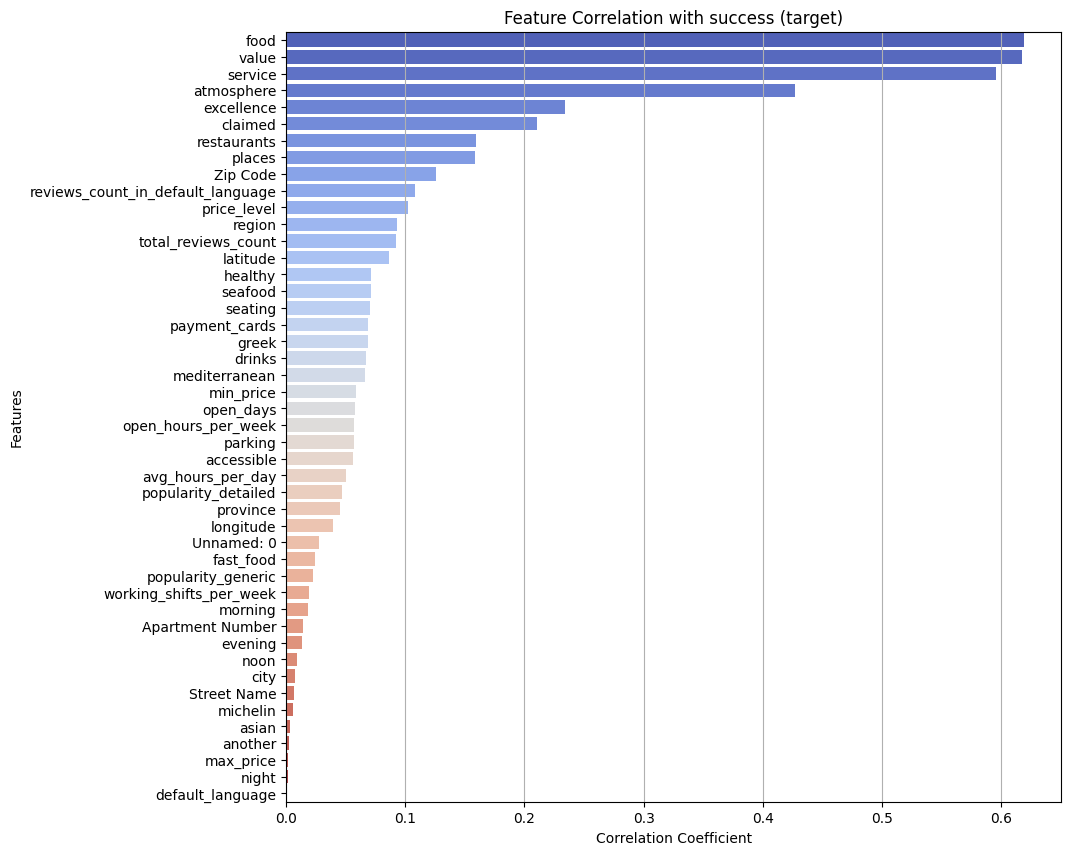

In [66]:
# Sample 10,000 random rows
#df_sampled = df3.sample(n=15_000, random_state=42)

# Define target column name (change this to your actual target column)
target_column = "success (target)"

# Compute correlation of all features with the target
correlation_with_target = df3.corr()[target_column].drop(target_column)  # Exclude self-correlation

# Sort correlations by absolute value (optional, for better visualization)
correlation_with_target = correlation_with_target.abs().sort_values(ascending=False)

# Plot the correlations
plt.figure(figsize=(10, 10))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette="coolwarm")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.title(f"Feature Correlation with {target_column}")
plt.grid(axis="x")

# Show the plot
plt.show()

<ipython-input-67-33c85131907d>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette="coolwarm")


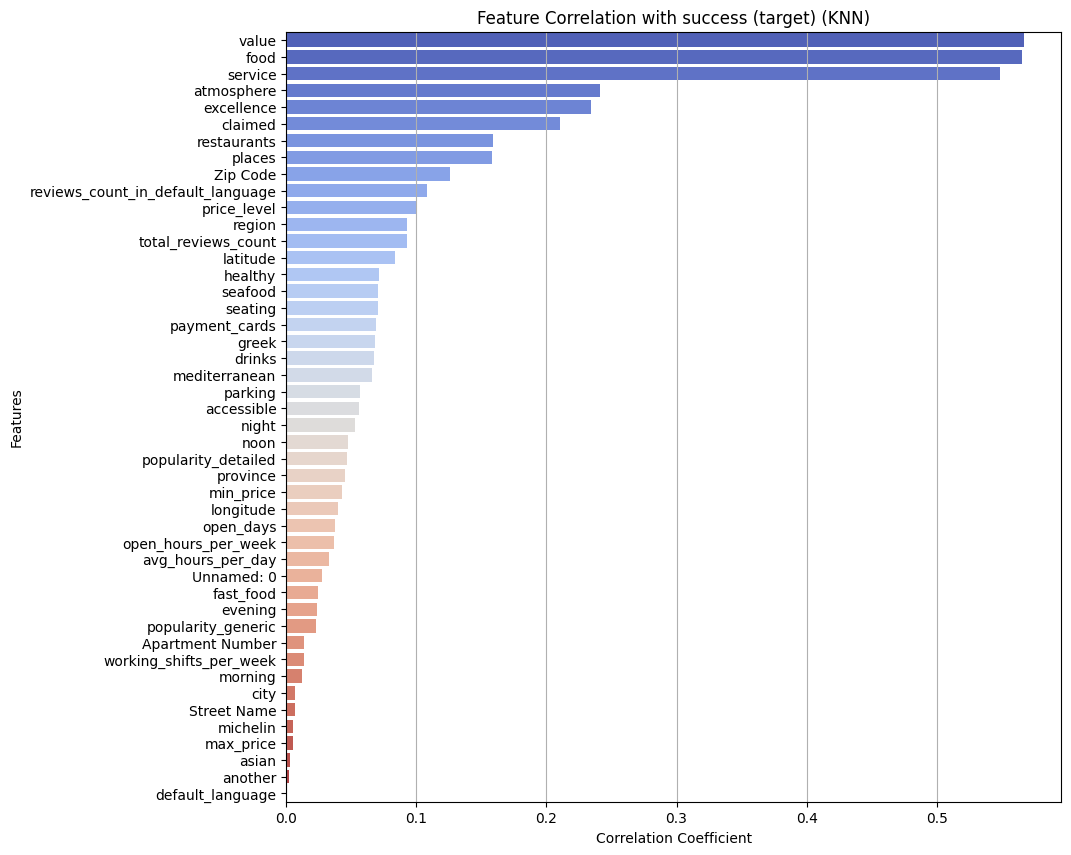

In [67]:
# Sample 10,000 random rows
#df_sampled = df3.sample(n=15_000, random_state=42)

# Define target column name (change this to your actual target column)
target_column = "success (target)"

# Compute correlation of all features with the target
correlation_with_target = df4.corr()[target_column].drop(target_column)  # Exclude self-correlation

# Sort correlations by absolute value (optional, for better visualization)
correlation_with_target = correlation_with_target.abs().sort_values(ascending=False)

# Plot the correlations
plt.figure(figsize=(10, 10))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette="coolwarm")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.title(f"Feature Correlation with {target_column} (KNN)")
plt.grid(axis="x")

# Show the plot
plt.show()

In [68]:
def outliers_df(df):
    total_outliers = pd.DataFrame(columns={'Outlier count','Percent'})
    for col in df:
        if col != 'target value':
            temp = pd.DataFrame(df[col], columns={col})
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            upper_limit = Q1 + 1.5 * (Q3-Q1)
            lower_limit = Q3 - 1.5 * (Q3-Q1)
            upper_outliers = temp[temp[col] > upper_limit]
            lower_outliers = temp[temp[col] < lower_limit]
            temp = upper_outliers.append(lower_outliers)
            b = "{}".format(col)
            num = len(temp)
            total_outliers.loc[b] = [num, num/len(df)*100]
    return total_outliers[total_outliers['Percent']>0]

outliers_df = outliers_df(df_num_non_dummy).sort_values('Percent', ascending=False)
outliers_df

NameError: name 'df_num_non_dummy' is not defined

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
df3['food'].value_counts()

In [ ]:
import sklearn.metrics as metrics
import math
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
#!pip install xgboost
import xgboost

In [ ]:
def regressionMetrics(y, yhat):
    res = {'MSE': metrics.mean_squared_error(y,yhat),
           'RMSE': np.sqrt(metrics.mean_squared_error(y,yhat)),
           'MAE': metrics.mean_absolute_error(y,yhat),
           'RMSLE': np.sqrt(metrics.mean_squared_log_error(y,yhat))
          }
    return res